##### 三类股票分类，
##### 使用未来三天的平均change来作为标签值y，并用0.33, 0.67分位值作为三类标签的划分边界

##### 数据: 基本指标 
##### 模型:  LSTM


In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from numpy import row_stack,column_stack
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY,YEARLY
# from mpl_finance import quotes_historical_yahoo_ohlc, candlestick_ohlc
from matplotlib.pylab import date2num
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation,Dropout
import tushare as ts
import datetime
import time

d:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### softmax三类分类写不出来，用回归代替

### 加工数据

In [2]:
ts.set_token('29ea8fa19e717f1a3d3618796f87067ee07219783a9e01422eb90ef8')
pro = ts.pro_api()

# df = ts.get_hist_data('601318',start='2009-01-01',end='2018-01-12') #一次性获取全部日k线数据
df = pro.daily(ts_code='000002.SZ', start_date = '20110701', end_date = '20181118')
df = df.iloc[::-1]
df.head()

df.to_csv('Vanke-from-20110701-to-20181118.csv', index=False)

df = pd.read_csv('Vanke-from-20110701-to-20181118.csv')
df.head()




,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000002.SZ,20110701,8.43,8.81,8.40,8.68,8.45,0.23,2.72,1277998.67,1.105772e+06
1,000002.SZ,20110704,8.73,8.97,8.68,8.71,8.68,0.03,0.35,832629.39,7.328196e+05
2,000002.SZ,20110705,8.71,9.02,8.71,8.84,8.71,0.13,1.49,1470530.64,1.307364e+06
3,000002.SZ,20110706,8.85,8.88,8.71,8.82,8.84,-0.02,-0.23,609540.69,5.355945e+05
4,000002.SZ,20110707,8.84,8.98,8.55,8.77,8.82,-0.05,-0.57,846650.10,7.444219e+05


In [3]:
input_data = df[['open','high','low','pre_close','change','pct_chg','vol','amount','close']]

In [4]:
# input_data['change'].quantile([0.33,0.5, 0.67,])
quantile033 = input_data['change'].quantile([0.33]).iloc[0]
quantile067 = input_data['change'].quantile([0.67]).iloc[0]

In [5]:
quantile033, quantile067

(-0.1, 0.09)

In [6]:
input_data['change'].median()

-0.01

In [7]:
data = input_data['change'].quantile([0.33,])

In [8]:
data.iloc[0]

-0.1

In [9]:
change = input_data['change']

In [10]:
ave_change_column = [ ]
for i in range(0, len(change)):
    if i >= len(change) - 3:
        ave_change = change[i]
        
    else:
        ave_change = (change[i+1] + change[i+2] + change[i+3]) / 3
    
    ave_change_column.append(ave_change)
#     if ave_change < quantile033:
#         trend_column.append(-1)
#     elif quantile033 <= ave_change <= quantile067:
#         trend_column.append(0)
#     else:
#         trend_column.append(1)


In [11]:
len(change) , len(ave_change_column)

(1645, 1645)

In [12]:
input_data['ave_change'] = ave_change_column

d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
input_data.head(15)

,open,high,low,pre_close,change,pct_chg,vol,amount,close,ave_change
0,8.43,8.81,8.40,8.45,0.23,2.72,1277998.67,1.105772e+06,8.68,0.046667
1,8.73,8.97,8.68,8.68,0.03,0.35,832629.39,7.328196e+05,8.71,0.020000
2,8.71,9.02,8.71,8.71,0.13,1.49,1470530.64,1.307364e+06,8.84,-0.006667
3,8.85,8.88,8.71,8.84,-0.02,-0.23,609540.69,5.355945e+05,8.82,-0.023333
4,8.84,8.98,8.55,8.82,-0.05,-0.57,846650.10,7.444219e+05,8.77,-0.090000
5,8.73,8.90,8.73,8.77,0.05,0.57,509852.92,4.501612e+05,8.82,-0.070000
6,8.75,8.78,8.60,8.82,-0.07,-0.79,426939.43,3.718344e+05,8.75,-0.056667
7,8.66,8.67,8.42,8.75,-0.25,-2.86,621564.65,5.294945e+05,8.50,-0.023333
8,8.49,8.71,8.47,8.50,0.11,1.29,426684.23,3.665039e+05,8.61,-0.083333
9,8.62,8.71,8.51,8.61,-0.03,-0.35,440302.90,3.784174e+05,8.58,-0.030000


In [14]:
data = input_data.values

dd1=input_data.sort_index()

dd2=dd1.values.flatten()

dd3=pd.DataFrame(dd1['close'])

In [15]:
def load_data(df, sequence_length=30, split=0.8):
    # 转为float型
    data_all = np.array(df.astype(float))
    # 标准化
    x_scaler = MinMaxScaler()
    data_all[:, :-1] = x_scaler.fit_transform(data_all[:, :-1])
    data = []
    for i in range(len(data_all) - sequence_length - 1):
        data.append(data_all[i: i + sequence_length + 1])
    reshaped_data = np.array(data).astype('float64')
    x = reshaped_data[:, :-1]
    y = reshaped_data[:, -1][:, -1]
    scaler = MinMaxScaler()
    y = scaler.fit_transform(y.reshape(-1, 1))
    split_boundary = int(reshaped_data.shape[0] * split)
    train_x = x[: split_boundary]
    test_x = x[split_boundary:]

    train_y = y[: split_boundary]
    test_y = y[split_boundary:]

    return train_x, train_y, test_x, test_y, scaler

In [16]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.5))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.4))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [17]:
def train_model(train_x, train_y, test_x, test_y):
    model = build_model([train_x.shape[2], train_x.shape[1], 100, 1])

    try:
        model.fit(train_x, train_y, batch_size=40, nb_epoch=100, validation_split=0.1)
        predict = model.predict(test_x)
        predict = np.reshape(predict, (predict.size, ))
    except KeyboardInterrupt:
        print(predict)
        print(test_y)
#     print(predict)
#     print(test_y)
    try:
        fig = plt.figure(1)
        plt.plot(predict, 'r:')
        plt.plot(test_y, 'g-')
        plt.legend(['predict', 'true'])
    except Exception as e:
        print(e)
    return predict, test_y , model

In [18]:
train_x, train_y, test_x, test_y, scaler =load_data(dd1, sequence_length=10, split=0.8)

In [19]:
print("train_x", train_x.shape)
print("train_y", train_y.shape)
print("test_x", test_x.shape)
print("test_y", test_y.shape)

train_x (1307, 10, 10)
train_y (1307, 1)
test_x (327, 10, 10)
test_y (327, 1)


d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 10), units=10)`
  
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Compilation Time :  0.031909942626953125
Train on 1176 samples, validate on 131 samples
Epoch 1/100
1176/1176 [==============================] - 2s 2ms/step - loss: 0.0196 - acc: 8.5034e-04 - val_loss: 0.0058 - val_acc: 0.0000e+00
Epoch 2/100
1176/1176 [==============================] - 1s 461us/step - loss: 0.0076 - acc: 0.0000e+00 - val_loss: 0.0052 - val_acc: 0.0000e+00
Epoch 3/100
1176/1176 [==============================] - 0s 364us/step - loss: 0.0066 - acc: 8.5034e-04 - val_loss: 0.0054 - val_acc: 0.0000e+00
Epoch 4/100
1176/1176 [==============================] - 0s 377us/step - loss: 0.0063 - acc: 0.0000e+00 - val_loss: 0.0083 - val_acc: 0.0000e+00
Epoch 5/100
1176/1176 [==============================] - 0s 353us/step - loss: 0.0057 - acc: 8.5034e-04 - val_loss: 0.0052 - val_acc: 0.0000e+00
Epoch 6/100
1176/1176 [==============================] - 0s 361us/step - loss: 0.0057 - acc: 8.5034e-04 - val_loss: 0.0054 - val_acc: 0.0000e+00
Epoch 7/100
1176/1176 [=====================

1176/1176 [==============================] - 0s 357us/step - loss: 0.0022 - acc: 0.0017 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 58/100
1176/1176 [==============================] - 0s 360us/step - loss: 0.0024 - acc: 0.0017 - val_loss: 0.0025 - val_acc: 0.0000e+00
Epoch 59/100
1176/1176 [==============================] - 0s 359us/step - loss: 0.0023 - acc: 0.0017 - val_loss: 0.0025 - val_acc: 0.0000e+00
Epoch 60/100
1176/1176 [==============================] - 0s 353us/step - loss: 0.0021 - acc: 0.0017 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 61/100
1176/1176 [==============================] - 0s 359us/step - loss: 0.0024 - acc: 0.0017 - val_loss: 0.0025 - val_acc: 0.0000e+00
Epoch 62/100
1176/1176 [==============================] - 0s 356us/step - loss: 0.0022 - acc: 8.5034e-04 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 63/100
1176/1176 [==============================] - 0s 352us/step - loss: 0.0022 - acc: 0.0017 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 64/100
11

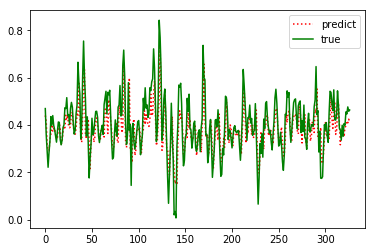

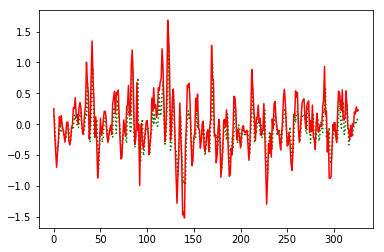

In [20]:
predict_y, test_y, model = train_model(train_x, train_y, test_x, test_y)
predict_y = scaler.inverse_transform([[i] for i in predict_y])
test_y = scaler.inverse_transform(test_y)
fig2 = plt.figure(2)
plt.plot(predict_y, 'g:')
plt.plot(test_y, 'r-')
plt.show()


In [21]:
trend_list = [1,]
for i in range(1, len(predict_y)):
    if predict_y[i] <= quantile033:
        trend_list.append(-1)
    elif quantile033 <= predict_y[i] <= quantile067:
        trend_list.append(0)
    else:
        trend_list.append(1)

real_trend_list = [1,]
for i in range(1, len(test_y)):
    if test_y[i] <= quantile033:
        real_trend_list.append(-1)
    elif quantile033 <= test_y[i] <= quantile067:
        real_trend_list.append(0)
    else:
        real_trend_list.append(1)
        
#     if ave_change < quantile033:
#         trend_column.append(-1)
#     elif quantile033 <= ave_change <= quantile067:
#         trend_column.append(0)
#     else:
#         trend_column.append(1)

true_count = 0
false_count = 0


print(len(test_y), len(predict_y))

pair_list = []

for i in range(len(predict_y)-1):
    pair_list.append([real_trend_list[i], trend_list[i]])
    if real_trend_list[i] == trend_list[i]:
        true_count = true_count + 1
    else:
        false_count = false_count + 1

# print(pair_list)
print(true_count, false_count)


327 327
201 125


In [22]:
len(real_trend_list) , len(trend_list)

(327, 327)

In [23]:
accuracy = true_count/ len(predict_y)
accuracy

0.6146788990825688

In [24]:
from collections import Counter

result = Counter(trend_list)
print ("预测数据", result)
result = Counter(real_trend_list)
print ("真实数据", result)

预测数据 Counter({-1: 156, 0: 97, 1: 74})
真实数据 Counter({-1: 135, 1: 126, 0: 66})


In [25]:
# count = 0
# for i in predict_y:
#     if quantile033 < i < quantile067:
#         count += 1

# print(count)

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 10)          840       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 10)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               44400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 45,341
Trainable params: 45,341
Non-trainable params: 0
_________________________________________________________________


In [27]:
real_df = pd.DataFrame(real_trend_list)
pred_df = pd.DataFrame(trend_list)
acc_df = pd.concat((real_df[0],pred_df[0]), axis=1)
acc_df

,0,0
0,1,1
1,-1,0
2,-1,-1
3,-1,-1
4,-1,-1
5,-1,-1
6,1,-1
7,0,0
8,1,-1
9,0,0


In [28]:
temp_list = []
temp_df =  real_df[0] - pred_df[0]
for i in range(0, len(temp_df)):
    temp_list.append([i, temp_df[i]])

In [29]:
%matplotlib qt
plt.clf()
plt.figure()
plt.scatter( *zip(*temp_list), )
# plt.scatter(real_df.index.values, pred_df[0],color='blue', marker='^')
# plt.scatter(real_df.index.values, real_df[0],color='red', marker='.')
plt.title('Trend Prediction Accuracy of individual Index = {}'.format(accuracy))
plt.xlabel('Days')
plt.ylabel('Trend Prediction')
plt.show()

In [30]:
%matplotlib qt
plt.clf()
fig2 = plt.figure()
plt.plot(predict_y, 'b-',label = 'predict ave change')
plt.plot(test_y, 'r-', label = 'true ave change')
plt.title('individual index model change price prediction')
plt.xlabel('Days')
plt.ylabel('change price')
plt.legend()
plt.show()

In [31]:
df.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000002.SZ,20110701,8.43,8.81,8.40,8.68,8.45,0.23,2.72,1277998.67,1.105772e+06
1,000002.SZ,20110704,8.73,8.97,8.68,8.71,8.68,0.03,0.35,832629.39,7.328196e+05
2,000002.SZ,20110705,8.71,9.02,8.71,8.84,8.71,0.13,1.49,1470530.64,1.307364e+06
3,000002.SZ,20110706,8.85,8.88,8.71,8.82,8.84,-0.02,-0.23,609540.69,5.355945e+05
4,000002.SZ,20110707,8.84,8.98,8.55,8.77,8.82,-0.05,-0.57,846650.10,7.444219e+05


In [32]:
df.shape, input_data.shape

((1645, 11), (1645, 10))

In [33]:
new_data = df.copy()
new_data['ave_change'] = input_data['ave_change']

In [34]:
train_x.shape, test_x.shape

((1307, 10, 10), (327, 10, 10))

In [35]:
new_data.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,ave_change
0,000002.SZ,20110701,8.43,8.81,8.40,8.68,8.45,0.23,2.72,1277998.67,1.105772e+06,0.046667
1,000002.SZ,20110704,8.73,8.97,8.68,8.71,8.68,0.03,0.35,832629.39,7.328196e+05,0.020000
2,000002.SZ,20110705,8.71,9.02,8.71,8.84,8.71,0.13,1.49,1470530.64,1.307364e+06,-0.006667
3,000002.SZ,20110706,8.85,8.88,8.71,8.82,8.84,-0.02,-0.23,609540.69,5.355945e+05,-0.023333
4,000002.SZ,20110707,8.84,8.98,8.55,8.77,8.82,-0.05,-0.57,846650.10,7.444219e+05,-0.090000


In [36]:
new_data['ave_change'].iloc[1317:].head(20)

1317    0.253333
1318   -0.173333
1319   -0.446667
1320   -0.696667
1321   -0.453333
1322   -0.266667
1323    0.123333
1324   -0.016667
1325    0.140000
1326   -0.016667
1327   -0.086667
1328   -0.193333
1329   -0.290000
1330   -0.113333
1331    0.036667
1332    0.030000
1333   -0.250000
1334   -0.333333
1335   -0.260000
1336   -0.053333
Name: ave_change, dtype: float64

In [37]:
test_y[0:20] , predict_y[0:5]

(array([[ 0.25333333],
        [-0.17333333],
        [-0.44666667],
        [-0.69666667],
        [-0.45333333],
        [-0.26666667],
        [ 0.12333333],
        [-0.01666667],
        [ 0.14      ],
        [-0.01666667],
        [-0.08666667],
        [-0.19333333],
        [-0.29      ],
        [-0.11333333],
        [ 0.03666667],
        [ 0.03      ],
        [-0.25      ],
        [-0.33333333],
        [-0.26      ],
        [-0.05333333]]), array([[ 0.14180913],
        [ 0.04425428],
        [-0.32330273],
        [-0.41681807],
        [-0.42800613]]))

In [38]:
save_data = new_data[1317:-1]

In [39]:
save_data.shape , test_x.shape, predict_y.shape , len(trend_list), len(real_trend_list)

((327, 12), (327, 10, 10), (327, 1), 327, 327)

In [40]:
save_data['pred_ave_change'] = predict_y

d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [41]:
save_data['real_trend'] = real_trend_list
save_data['pred_trend'] = trend_list

d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [42]:
save_data.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,ave_change,pred_ave_change,real_trend,pred_trend
1317,000002.SZ,20170714,24.45,24.83,24.36,24.59,24.43,0.16,0.65,201797.31,495832.293,0.253333,0.141809,1,1
1318,000002.SZ,20170718,25.58,25.80,24.88,25.30,24.59,0.71,2.89,791833.77,2004962.442,-0.173333,0.044254,-1,0
1319,000002.SZ,20170719,24.85,26.06,24.43,25.14,25.30,-0.16,-0.63,1008070.70,2526934.175,-0.446667,-0.323303,-1,-1
1320,000002.SZ,20170720,24.85,25.64,24.73,25.35,25.14,0.21,0.84,633677.05,1598967.701,-0.696667,-0.416818,-1,-1
1321,000002.SZ,20170721,25.19,25.64,24.65,24.78,25.35,-0.57,-2.25,477662.55,1195588.636,-0.453333,-0.428006,-1,-1


In [43]:
save_data.to_csv('1-Result-Vanke-from-20110701-to-20181118.csv', index=False)

In [44]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model1.png', show_shapes=True)

In [45]:
from graphviz import Digraph